# U-Net++

This notebook is to train and test the performance of U-Net++

# Drive, libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import time

# Import data

## DIW

In [3]:
#  When working on Google drive it's easier and faster to unzip all the images on the virtual directory
import zipfile

start = time.time()

zip_file_path = "/content/drive/MyDrive/depth_estimation/DIW/test_200_200.zip"
destination_folder = "DIW/test_200_200/"
os.makedirs(destination_folder, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r')   as zip_ref:
    zip_ref.extractall(destination_folder)

print(f'Images extracted to {destination_folder}')
print("Execution time: ", time.time() - start)

Images extracted to DIW/test_200_200/
Execution time:  66.4668550491333


In [4]:
img_path = destination_folder+"test_200_200/"
os.listdir(img_path)

['test', 'train', 'val']

In [5]:
# The number of images has to be equal to the dataframes size
tr, v, t = img_path + "train/", img_path + "val/", img_path + "test/"
train_paths, val_paths, test_paths = sorted(os.listdir(tr)), sorted(os.listdir(v)), sorted(os.listdir(t))

len(train_paths), len(val_paths), len(test_paths)

(51751, 11089, 11090)

In [6]:
# Importing the train, validation and test dataframes

df_folder = "/content/drive/MyDrive/depth_estimation/DIW/" # Colab
# df_folder = "" # Local

train_df = pd.read_csv(df_folder + "df_train.csv").iloc[:,1:]
val_df = pd.read_csv(df_folder + "df_val.csv").iloc[:,1:]
test_df = pd.read_csv(df_folder + "df_test.csv").iloc[:,1:]

train_df = train_df.sort_values(by=['filename'],ascending=True)
val_df = val_df.sort_values(by=['filename'],ascending=True)
test_df = test_df.sort_values(by=['filename'],ascending=True)

# Print the sizes of the sets
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 51751
Validation set size: 11089
Test set size: 11090


In [ ]:
# Code to show some images
from PIL import Image
img_folder = img_path + "train/"

samples = train_df.sample(10, random_state=16)
samples = train_df.iloc[:10,:]
display(samples)

for index, sample in samples.iterrows():

    # Image path
    path = img_folder + sample['filename']
    # Annotations
    ya, xa, yb, xb, ordinal = sample['y_a'], sample['x_a'], sample['y_b'], sample['x_b'], sample['ordinal']

    image = Image.open(path)
    img = np.array(image)

    # Depth relation
    if ordinal == -1:
        text = "B is closer than A"
    else:
        text = "A is closer than B"

    plt.imshow(img)
    plt.scatter(xa, ya, color="red", marker='x', s=100, label='A')
    plt.scatter(xb, yb, color="green", marker='x', s=100, label='B')
    plt.title("Image " + str(index) + "\n " + text)
    plt.legend()
    plt.axis("off")
    plt.show()

In [ ]:
# Checking files syncronization
# Due to the way the DataLoaders are implemented, the list of images and the annotations dataframes need to be syncronized (corted alhabetically)
train = (train_paths == train_df['filename']).values.astype(int)
val = (val_paths == val_df['filename']).values.astype(int)
test = (test_paths == test_df['filename']).values.astype(int)

train.sum() == len(train), val.sum() == len(val), test.sum() == len(test)

(True, True, True)

### DataLoaders

The DataLoaders will be used as data generators to train and test the model

In [7]:
import torch
from PIL import Image  # Import the Image module from the PIL package
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Path to the folder containing images
# image_folder =  "/content/drive/MyDrive/depth_estimation/DIW/test_200_200/test_200_200/" # Colab
image_folder =  img_path # Colab
# image_folder = "/Users/ismas/Downloads/DIW/test_200_200/" # Local

# Define a transformation to be applied to each image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])

# Custom dataset class
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, df, transform=None):
        self.folder_path = folder_path
        self.transform = transform

        # List of all image files in the folder
        self.image_files = df['filename'].values
        self.df = df

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Read the image
        image_path = os.path.join(self.folder_path, self.image_files[idx])
        # image = torchvision.io.read_image(image_path)
        image = Image.open(image_path).convert("RGB")  # Ensure the image is in RGB format

        # Take the annotations using the same index
        # label = self.df[self.df['filename']==self.image_files[idx]].values
        label = self.df.iloc[idx, 1:-2].values
        label = np.append(label, idx).astype('float')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image.permute(1, 2, 0), label

# Create an instance of the custom dataset
train_dataset_diw = CustomImageDataset(image_folder + "train/", train_df, transform=transform)
val_dataset_diw = CustomImageDataset(image_folder + "val/", val_df, transform=transform)
test_dataset_diw = CustomImageDataset(image_folder + "test/", test_df, transform=transform)

# Create a DataLoader for batching and shuffling the data
batch_size = 32
num_workers = 2
train_loader_diw = DataLoader(train_dataset_diw, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
val_loader_diw = DataLoader(val_dataset_diw, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
test_loader_diw = DataLoader(test_dataset_diw, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

# Example of usage to show all shapes
i = 0
for train, val, test in zip(train_loader_diw, val_loader_diw, test_loader_diw):

    train_image, train_label = train
    val_image, val_label = val
    test_image, test_label = test
    print(train_image.shape, train_label.shape, val_image.shape, val_label.shape, test_image.shape, test_label.shape)
    i+=1
    if i == 5:
      break

torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6])
torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6])
torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6])
torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6])
torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6])


In [47]:
# Code to plot images showing also the depth relation
def plot_img(img, label, legend = True, id=''):

  # ya, xa, yb, xb, ordinal = row['y_A'], row['x_A'], row['y_B'], row['x_B'], row['ordinal']
  xa, ya, xb, yb, ordinal = label

  if ordinal == 1:
      text = "A is closer than B"
  else:
      text = "B is closer than A"

  plt.imshow(img)
  plt.scatter(xa, ya, color="red", marker='x', s=100, label='A')
  plt.scatter(xb, yb, color="green", marker='x', s=100, label='B')

  if id != '': # id is the id of the image
    id = id + " - "
  plt.title(id + text)
  if legend:
      plt.legend()
  plt.axis("off")
  # plt.show()

[   99   161   168   191    -1 26732]
['6bfe7e2feec3a3dd84f74e47a8d42a9f278f7e82.jpg' 99 161 168 191 -1 200 200]

[   27    92   172    92    -1 21076]
['4ff972a8dc07a30681074042651ddbc951899c81.jpg' 27 92 172 92 -1 200 200]

[   83   134   116   134    -1 46161]
['dcbebf74373bc7bf97dfd73985121f04ec54b288.jpg' 83 134 116 134 -1 200 200]

[   24   120   176   120    -1 23806]
['5cf5096487b6f569239170a583dee3edf76b4ab5.jpg' 24 120 176 120 -1 200 200]

[  182   191    67    86    -1 44857]
['d49cb31e34b68324520c28a7cc85dbec75cb4e4c.jpg' 182 191 67 86 -1 200 200]



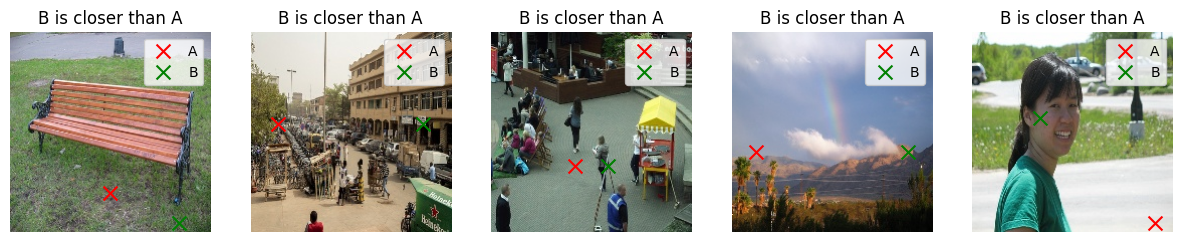

In [48]:
# Showing some images from the DataLoaders
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    random_index = torch.randint(0, len(train_dataset_diw), (1,)).item()
    image, label = train_dataset_diw[random_index]

    print(label.astype(int))
    print(train_df.iloc[label[-1].astype(int),:].values)
    print()
    image = np.asarray(image*255).astype(np.uint8) # Image converted to int for correct visualization
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(1,5,i+1)
    plot_img(image, label[:-1])

plt.show()

[ 12  99 188  99  -1   0]
['000041f0d9f4c43096ab0c92c898a85b31e55bc9.jpg' 12 99 188 99 -1 200 200]

[ 82  21 118  21  -1   1]
['00011ba2991d1731c0ba690fbe5bb6e4fb810efc.jpg' 82 21 118 21 -1 200 200]

[ 70 128 130 128  -1   2]
['0001a925b067511627b0a577e6585dcc06c72555.jpg' 70 128 130 128 -1 200 200]

[ 58  66 141  66   1   3]
['0001d62f54748281b84a3afd667b1f4a0eece4b4.jpg' 58 66 141 66 1 200 200]

[182 170  19  17   1   4]
['00020d04ebf87cec42892c7e10ddae57eda579be.jpg' 182 170 19 17 1 200 200]



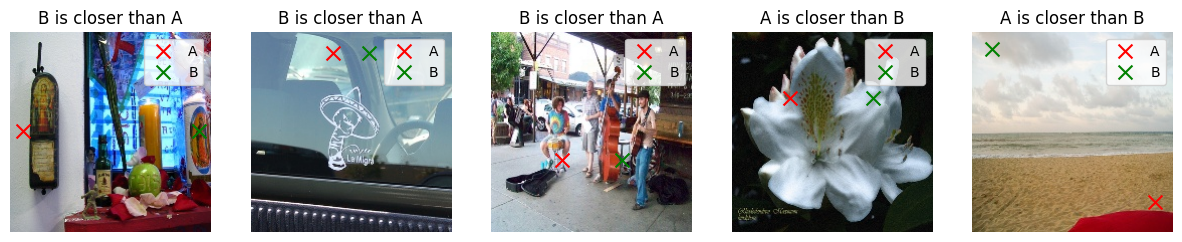

In [53]:
# Showing some images from the DataLoaders
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for images, labels in train_loader_diw:
  # random_index = torch.randint(0, len(train_dataset_diw), (1,)).item()
  # image, label = train_dataset_diw[random_index]

  for i in range(5):
    image, label = images[i], labels[i].numpy()
    print(label.astype(int))
    print(train_df.iloc[label[-1].astype(int),:].values)
    print()
    image = np.asarray(image*255).astype(np.uint8) # Image converted to int for correct visualization
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(1,5,i+1)
    plot_img(image, label[:-1])
  break

plt.show()

## NYU

In [3]:
# Import of the arrays with the images and depths
images_path = "/content/drive/MyDrive/depth_estimation/NYU/img_200_200.npy"
depths_path = "/content/drive/MyDrive/depth_estimation/NYU/depth_200_200.npy"

x, y = np.load(images_path), np.load(depths_path)
x.shape, y.shape

((1449, 200, 200, 3), (1449, 200, 200))

In [4]:
# Normalizing depths
y_norm = y.copy()
for i in range(y.shape[0]):
  img = y[i]
  y_norm[i] = (img - np.min(img)) / (np.max(img) - np.min(img))

np.min(y_norm), np.max(y_norm)

y = y_norm

In [5]:
# Checking normalization in the depths
np.min(x), np.max(x), np.min(y), np.max(y)

(0.0, 255.0, 0.0, 1.0)

In [6]:
# Train, validation and test split
# Proportions are 0.7, 0.15, 0.15
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size=0.5)

print("Train shape: ", x_train.shape, y_train.shape)
print("Val   shape: ", x_val.shape, y_val.shape)
print("Test  shape: ", x_test.shape, y_test.shape)

Train shape:  (1014, 200, 200, 3) (1014, 200, 200)
Val   shape:  (217, 200, 200, 3) (217, 200, 200)
Test  shape:  (218, 200, 200, 3) (218, 200, 200)


### DataLoaders

The DataLoaders will be used as data generators to train and test the model

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert numpy arrays to PyTorch tensors
timages_tensor, tlabels_tensor = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
vimages_tensor, vlabels_tensor = torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
ttimages_tensor, ttlabels_tensor = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create a TensorDataset
train_dataset_nyu = TensorDataset(timages_tensor, tlabels_tensor)
val_dataset_nyu = TensorDataset(vimages_tensor, vlabels_tensor)
test_dataset_nyu = TensorDataset(ttimages_tensor, ttlabels_tensor)

# Create a DataLoader
batch_size = 32
train_loader_nyu = DataLoader(train_dataset_nyu, batch_size=batch_size, shuffle=True, drop_last = True)
val_loader_nyu = DataLoader(val_dataset_nyu, batch_size=batch_size, shuffle=True, drop_last = True)
test_loader_nyu = DataLoader(test_dataset_nyu, batch_size=batch_size, shuffle=True, drop_last = True)

# Iteration to show the shapes
for train, val, test in zip(train_loader_nyu, val_loader_nyu, test_loader_nyu):
  timages, tdepths = train
  vimages, vdepths = train
  ttimages, ttdepths = train

  print(timages.shape, tdepths.shape, vimages.shape, vdepths.shape, ttimages.shape, ttdepths.shape)
  break

del x, y, y_norm, x_train, y_train, x_val, y_val, x_test, y_test

torch.Size([32, 200, 200, 3]) torch.Size([32, 200, 200]) torch.Size([32, 200, 200, 3]) torch.Size([32, 200, 200]) torch.Size([32, 200, 200, 3]) torch.Size([32, 200, 200])


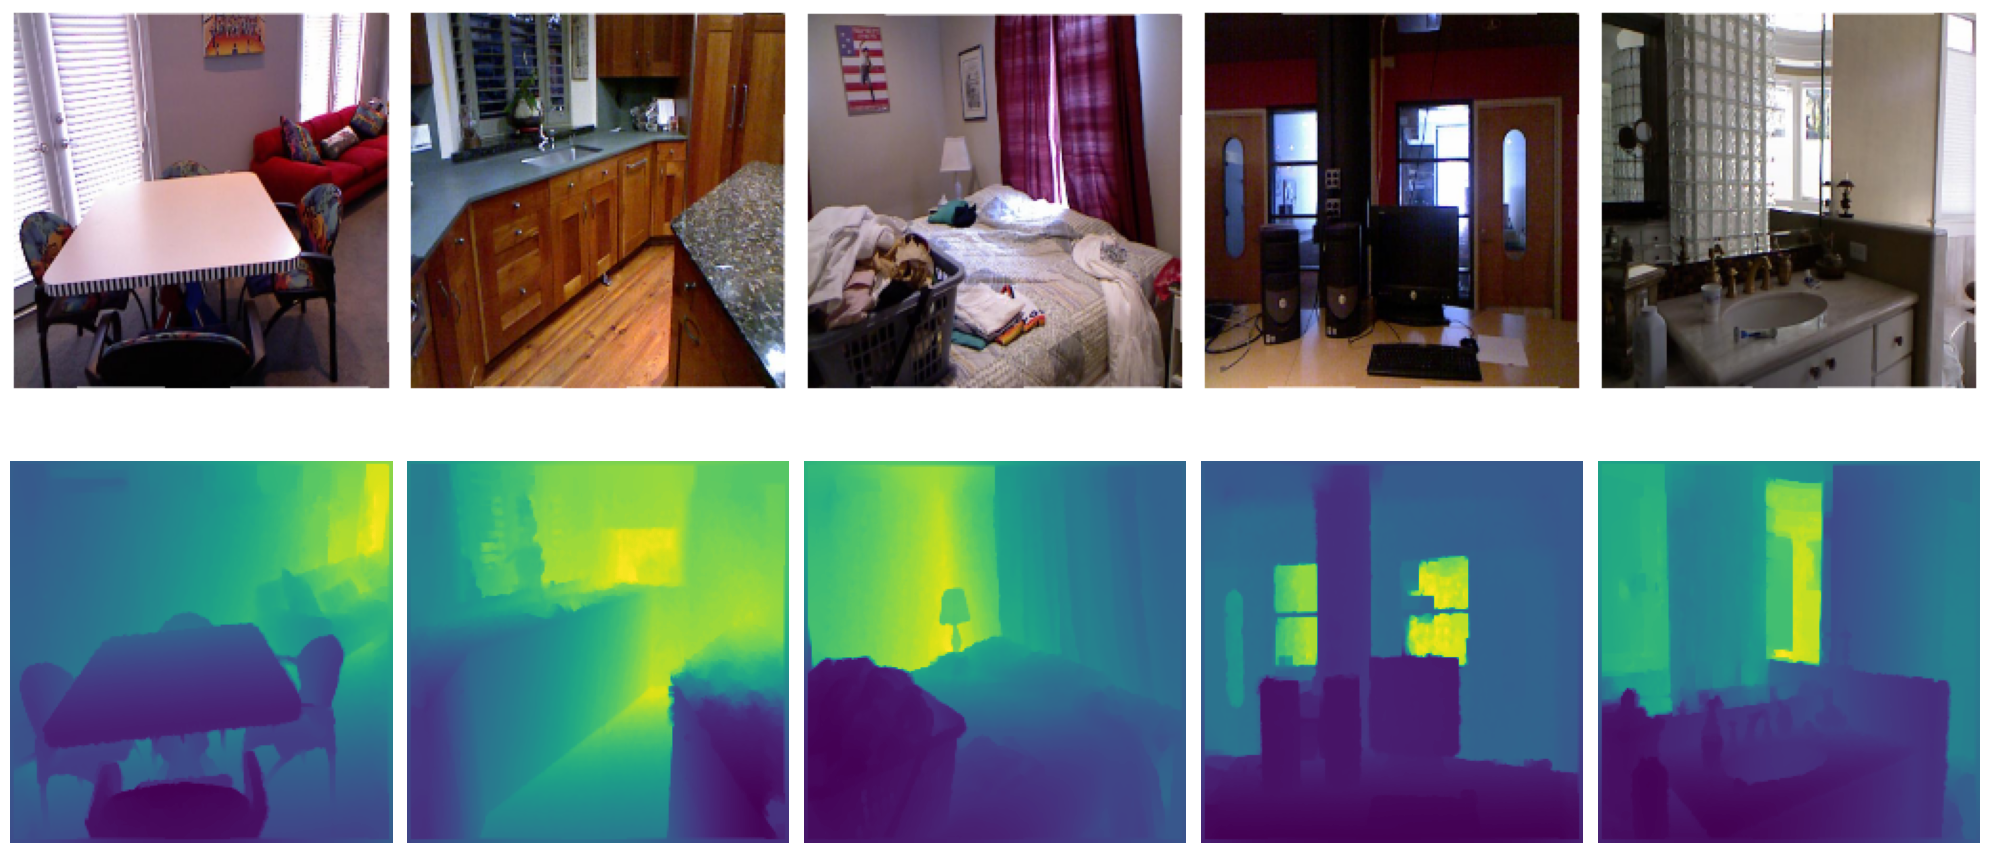

In [ ]:
# Visualizing examples

n_cols = 5

fig, axs = plt.subplots(2, n_cols, figsize=(20, 10))

for i in range(n_cols):

    axs[0, i].imshow(timages[i].numpy().astype(np.uint8))
    axs[0, i].axis('off')
    axs[1, i].imshow(tdepths[i])
    axs[1, i].axis('off')

plt.tight_layout()

# Show the plot
plt.show()

# UNET

In [8]:
!pip install -Uq segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.8 MB/s eta 0:00:00


In [9]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 6.2 MB/s eta 0:00:00


In [10]:
import pandas as pd
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
from pathlib import Path
import segmentation_models_pytorch as smp
import gc
from torchvision.transforms import Normalize
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
class UNet(nn.Module):
    def __init__(self,):
        super().__init__()
        self.model = smp.UnetPlusPlus(
            encoder_name='resnext50_32x4d',
            in_channels=3,
            classes=1
        )

    def trainable_encoder(self,trainable=True):
        for p in self.model.encoder.parameters():
            p.requires_grad = trainable

    def forward(self,x):
        return self.model(x)

    def _num_params(self,):
        return sum([p.numel() for p in self.model.parameters() if p.requires_grad])

## Train NYU

In [13]:
epochs = 10
freeze_epochs = 2
lr = 1e-3

train_steps, val_steps = len(train_dataset_nyu), len(val_dataset_nyu)

model = UNet().to(device)
model.trainable_encoder(trainable=False)

loss_fn = nn.MSELoss()
optim = torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=0.02)
sched = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=lr,epochs=epochs,steps_per_epoch=train_steps)

scaler = GradScaler()

/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [14]:
print("Total parameters: ", sum(p.numel() for p in model.parameters()))
print("Trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Total parameters:  48457617
Trainable parameters:  25477713


In [15]:
model.load_state_dict(torch.load('/content/drive/MyDrive/depth_estimation/nyu-v2-depth-resnext50_32x4d-unetplusplus.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
best_loss = 1000
best_epoch = -1
train_loss, val_loss = [], []
print('training decoder only')

for epoch in tqdm(range(epochs)):

    model.train()

    if epoch == freeze_epochs:
        model.trainable_encoder(trainable=True)
        print('training encoder and decoder both')

    running_loss = 0.

    n = 0
    for img, mask in train_loader_nyu:

        with autocast():
            img, mask = img.permute(0,3,1,2), mask
            img = transforms.functional.resize(img, 224, antialias=True).to(device)
            mask = transforms.functional.resize(mask, 224, antialias=True).to(device)

            preds = model(img).view(32, 224, 224)

            loss = loss_fn(preds,mask)
            scaler.scale(loss).backward()
            scaler.unscale_(optim)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            scaler.step(optim)
            scaler.update()
            sched.step()
            optim.zero_grad()

            running_loss += loss.item() * img.shape[0]

            n += 1
            if n == train_steps:
              break

        del img, mask, preds, loss

    print(f' epoch {epoch} train loss: {running_loss/train_steps}')
    train_loss.append(running_loss/train_steps)
    model.eval()

    with torch.no_grad():

        running_loss = 0.

        n = 0
        for img, mask in val_loader_nyu:

            with autocast():
                img, mask = img.permute(0,3,1,2), mask
                img = transforms.functional.resize(img, 224, antialias=True).to(device)
                mask = transforms.functional.resize(mask, 224, antialias=True).to(device)
                preds = model(img).view(32, 224, 224)
                loss = loss_fn(preds,mask)
                running_loss += loss.item() * img.shape[0]

                n += 1
                if n == val_steps:
                  break

            del img, mask, preds, loss

        print(f' epoch {epoch} val loss: {running_loss/val_steps}')
        val_loss.append(running_loss/val_steps)
    print()

    if (running_loss/val_steps) < best_loss:
      best_loss = running_loss/val_steps
      best_epoch = epoch
      sd = model.state_dict()
      torch.save(sd,'nyu-v2-depth-resnext50_32x4d-unetplusplus.pt')

    gc.collect()
    torch.cuda.empty_cache()

training decoder only


  0%|          | 0/10 [00:00<?, ?it/s]

 epoch 0 train loss: 0.32749425353853423
 epoch 0 val loss: 0.1579901238190963

 epoch 1 train loss: 0.09758472560190355
 epoch 1 val loss: 0.07899342154577581

training encoder and decoder both
 epoch 2 train loss: 0.06133222873864559
 epoch 2 val loss: 0.053199286834435526

 epoch 3 train loss: 0.04030032646961701
 epoch 3 val loss: 0.04207188742501395

 epoch 4 train loss: 0.02739422384803817
 epoch 4 val loss: 0.03906391458027923

 epoch 5 train loss: 0.02105716194156594
 epoch 5 val loss: 0.03569391136345226

 epoch 6 train loss: 0.017106824725337283
 epoch 6 val loss: 0.03338388144145913

 epoch 7 train loss: 0.014424802019045902
 epoch 7 val loss: 0.0331593449763988

 epoch 8 train loss: 0.012814458393486293
 epoch 8 val loss: 0.03251854560342252

 epoch 9 train loss: 0.01157766821586639
 epoch 9 val loss: 0.03087832685989169



In [ ]:
for img, mask in train_loader_nyu:

  img, mask = img.permute(0,3,1,2), mask
  img = transforms.functional.resize(img, 224, antialias=True).to(device)
  mask = transforms.functional.resize(mask, 224, antialias=True).to(device)

  preds = model(img).view(32, 224, 224)
  break
preds.shape

torch.Size([32, 224, 224])

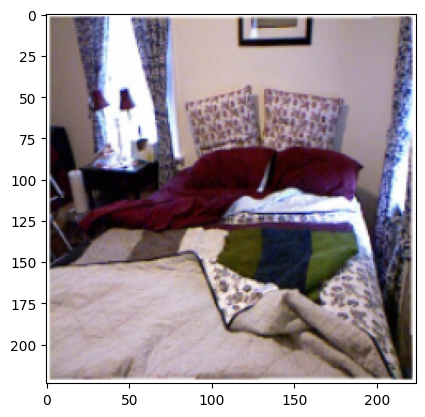

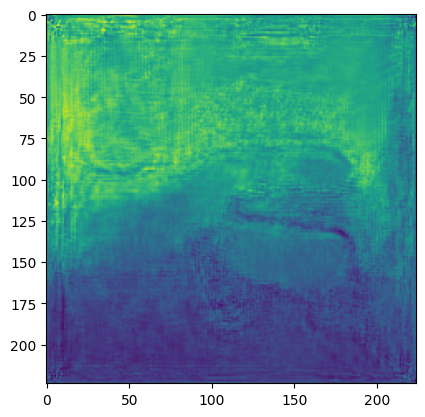

In [ ]:
a = img[0]
a = (a - torch.min(a)) / (torch.max(a) - torch.min(a))
plt.imshow(a.permute(1,2,0).cpu())
plt.show()
plt.imshow(preds[0].detach().cpu())

## Training DIW

In [12]:
import torch
import torch.nn.functional as F

def custom_loss(y_pred, y_true):
    # y_pred (batch_size, 1, width, height)
    # y_true (batch_size, 5) -> x_A, y_A, x_B, y_B, ordinal
    # print(y_true.shape, y_pred.shape)

    # Extract the coordinates and ordinal value from y_true
    coord1, coord2, ordinal = y_true[:, :2].long(), y_true[:, 2:4].long(), y_true[:, 4]

    # Extract the values of the two pixels using the coordinates
    pixel1 = y_pred[torch.arange(y_pred.size(0)), coord1[:, 1], coord1[:, 0]]
    pixel2 = y_pred[torch.arange(y_pred.size(0)), coord2[:, 1], coord2[:, 0]]

    # Loss based on the ordinal value for each batch element
    losses = torch.where(ordinal == 1,
                         torch.log(1 + torch.exp(-pixel1 + pixel2)),
                         torch.log(1 + torch.exp(pixel1 - pixel2)))

    # Take the mean of the losses across the batch
    loss = torch.mean(losses)

    return loss

In [13]:
epochs = 10
freeze_epochs = 0
lr = 1e-3

train_steps, val_steps = len(train_dataset_diw), len(val_dataset_diw)
save_path ='/content/drive/MyDrive/depth_estimation/diw-v2-depth-resnext50_32x4d-unetplusplus_2.pt'

model = UNet().to(device)
model.trainable_encoder(trainable=False)

loss_fn = custom_loss
optim = torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=0.02)
sched = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=lr,epochs=epochs,steps_per_epoch=train_steps)

scaler = GradScaler()

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 150MB/s]
/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [14]:
model.load_state_dict(torch.load('/content/drive/MyDrive/depth_estimation/nyu-v2-depth-resnext50_32x4d-unetplusplus.pt', map_location=torch.device('cpu')))
# model.load_state_dict(torch.load('/content/drive/MyDrive/depth_estimation/diw-v2-depth-resnext50_32x4d-unetplusplus.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
best_loss = 1000
best_epoch = -1
train_loss, val_loss = [], []
print('training decoder only')

for epoch in tqdm(range(epochs)):

    model.train()

    if epoch == freeze_epochs:
        model.trainable_encoder(trainable=True)
        print('training encoder and decoder both')

    running_loss = 0.

    for n, data in enumerate(train_loader_diw):

        with autocast():
            img, mask = data
            img, mask = img.permute(0,3,1,2)*255, mask
            img = transforms.functional.resize(img, 224, antialias=True).to(device)
            mask = mask.to(device)

            preds = model(img).view(32, 224, 224)

            loss = loss_fn(preds,mask)
            scaler.scale(loss).backward()
            scaler.unscale_(optim)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            scaler.step(optim)
            scaler.update()
            sched.step()
            optim.zero_grad()

            running_loss += loss.item() * img.shape[0]

            if n == train_steps:
              break

        del img, mask, preds, loss

    print(f' epoch {epoch} train loss: {running_loss/train_steps}')
    train_loss.append(running_loss/train_steps)
    model.eval()

    with torch.no_grad():

        running_loss = 0.

        for n, data in enumerate(val_loader_diw):

            with autocast():
                img, mask = data
                img, mask = img.permute(0,3,1,2), mask
                img = transforms.functional.resize(img, 224, antialias=True).to(device)
                mask = mask.to(device)
                preds = model(img).view(32, 224, 224)
                loss = loss_fn(preds,mask)
                running_loss += loss.item() * img.shape[0]

                # n += 1
                if n == val_steps:
                  break

            del img, mask, preds, loss

        print(f' epoch {epoch} val loss: {running_loss/val_steps}')
        val_loss.append(running_loss/val_steps)
    print()

    if (running_loss/val_steps) < best_loss:
      best_loss = running_loss/val_steps
      best_epoch = epoch
      sd = model.state_dict()
      torch.save(sd,save_path)

    gc.collect()
    torch.cuda.empty_cache()

# Testing

## WKDR

In [28]:
# WKDR
def get_depth_relation(img, p1, p2):
    """
    * img: redicted depth image
    * p1, p2: (x,y) coords of the A and B points respectively
    * threshold: threshold value for the equal depth
    """

    pixel1, pixel2 = img[p1], img[p2]

    if pixel1 > pixel2: # B is closer than A
        return 0
    else:               # A is closer than B
        return 1

def compute_accuracy_dataset(data_loader, iters, verbose = True):
    """
    * dataset: data_loader, train, validation or test
    * iters: number of iterations for the tf.dataset
    * verbose: print results at the end
    """

    performance = []

    count = 0

    for images, targets in data_loader:
        print(count, end="-")

        # if count % 10 == 0:
          # print(count, end="-")
        img, mask = images.permute(0,3,1,2)*255, targets
        img = transforms.functional.resize(img, 224, antialias=True).to(device)
        mask = mask.to(device)
        predictions = model(img).view(32, 224, 224).detach()

        for i in range(batch_size):

            x_a, y_a, x_b, y_b, ordinal,_ = targets[i].numpy().astype('int')

            true_relation = 1 if ordinal == 1 else 0 # 1 -> A is closer | 0 -> B is closer

            if predictions[i, y_a, x_a] > predictions[i, y_b, x_b]:
                # B is closer than A
                pred_relation = 0
            else:
                # A is closer than B
                pred_relation = 1

            performance.append(true_relation == pred_relation)

        del img, mask, predictions
        count += 1
        if count == iters:
            print()
            break

    if verbose:
      print(f'Accuracy over {len(performance)} elements: {sum(performance)/len(performance)}')

    return performance

In [ ]:
# Accuracy

print("***** Train results *****")
compute_accuracy_dataset(train_loader_diw, len(train_df) // batch_size, verbose=True)
print("***** Validation results *****")
compute_accuracy_dataset(val_loader_diw, len(val_df) // batch_size, verbose=True)
print("***** Test results *****")
compute_accuracy_dataset(test_loader_diw, len(test_df) // batch_size, verbose=True)

## DIW

In [15]:
def plot_img(img, row, legend = True, id=''):

  # ya, xa, yb, xb, ordinal = row['y_A'], row['x_A'], row['y_B'], row['x_B'], row['ordinal']
  xa, ya, xb, yb, ordinal = row[0], row[1], row[2], row[3], row[4]

  if ordinal == 1:
      text = "A is closer than B"
  else:
      text = "B is closer than A"

  plt.imshow(img)
  plt.scatter(xa, ya, color="red", marker='x', s=100, label='A')
  plt.scatter(xb, yb, color="blue", marker='x', s=100, label='B')

  if id != '':
    id = id + " - "
  plt.title(id + text)
  if legend:
      plt.legend()
  plt.axis("off")
  # plt.show()

In [18]:
# Showing results
data = "test"

if data == "train":
  dataloader = train_loader_diw
elif data == "val":
  dataloader = val_loader_diw
elif data == "test":
  dataloader = test_loader_diw

model.eval()
os.makedirs("preds/", exist_ok=True)

for img, mask in dataloader:

  img, mask = img.permute(0,3,1,2)*255, mask
  img = transforms.functional.resize(img, 224, antialias=True).to(device)
  mask = mask.to(device)
  preds = model(img).view(32, 224, 224).detach()
  loss = loss_fn(preds,mask)

  for i in range(img.shape[0]):
    plt.subplot(1,2,1)
    image = img[i].permute(1,2,0).numpy().astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plot_img(image, mask[i], id=str(i))

    plt.subplot(1,2,2)
    plt.imshow(preds[i])
    plt.axis("off")

    a, b = mask[i][:2].numpy().astype('int'), mask[i][2:4].numpy().astype('int')
    values = np.asarray([preds[i,a[1], a[0]], preds[i,b[1], b[0]]])
    if values[0] > values[1]:
      title = "B is closer than A"
    else:
      title = "A is closer than B"
    # title = "A: " + str(np.round(values[0], 4)) + " B: "+ str(np.round(values[1], 4))
    plt.title(title)
    plt.scatter(a[0], a[1], color="red", marker='x', s=100, label='A')
    plt.scatter(b[0], b[1], color="blue", marker='x', s=100, label='B')
    plt.legend()
    plt.savefig("preds/diw_"+data+"_"+str(i)+".jpg")
    plt.show()
    # break
  break
del img, mask, preds, loss

Output hidden; open in https://colab.research.google.com to view.

In [19]:
# Code to download the folder with all the predictions
import zipfile

def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arc_name = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname=arc_name)

# Example usage:
folder_to_zip = '/content/preds/'
output_zip_path = 'UNet_preds.zip'

zip_folder(folder_to_zip, output_zip_path)

## NYU

In [20]:
# Showing results
data = "val"

if data == "train":
  dataloader = train_loader_nyu
elif data == "val":
  dataloader = val_loader_nyu
elif data == "test":
  dataloader = test_loader_nyu

model.eval()
os.makedirs("preds/", exist_ok=True)

for img, mask in dataloader:
  img, mask = img.permute(0,3,1,2), mask
  img = transforms.functional.resize(img, 224, antialias=True).to(device)
  mask = transforms.functional.resize(mask, 224, antialias=True).to(device)

  preds = model(img).view(32, 224, 224)

  loss = loss_fn(preds,mask)

  for i in range(img.shape[0]):
    plt.subplot(1,3,1)
    plt.imshow(img[i].permute(1,2,0).numpy().astype(np.uint8))
    plt.title(data + " - " + str(i))
    plt.axis("off")

    norm = mask[i]
    norm = (norm - torch.min(norm)) / (torch.max(norm) - torch.min(norm))
    plt.subplot(1,3,2)
    plt.imshow(norm)
    plt.title("Depth map")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(preds[i].detach())
    plt.title("Predicted depth")
    plt.axis("off")
    plt.savefig("preds/nyu_"+data+"_"+str(i)+".jpg")
    plt.show()
  break
del img, mask, preds, loss

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Code to download the folder with all the predictions
import zipfile

def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arc_name = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname=arc_name)

# Example usage:
folder_to_zip = '/content/preds/'
output_zip_path = 'UNet_preds.zip'

zip_folder(folder_to_zip, output_zip_path)